# S13 T01 Aprendizaje supervisado: Clasificación

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

from lazypredict.Supervised import LazyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE

In [2]:
# Air Delay data has integer numbers
pd.options.display.float_format = '{:.0f}'.format

# Read the data into a dataframe
df_leido = pd.read_csv('DelayedFlights.csv', sep=',')

# Cancelled and diverted flights are not considered delayed o not delayed. Thay need a separate analisys
df_leido = df_leido[(df_leido.Cancelled == 0) & (df_leido.Diverted == 0)]

# The index needs to be reset because I deleted lines
df_leido.reindex()

# Use a sample so that the memory does not overflow
# df_raw = df_leido.sample(frac=0.1, random_state=9)
# Instead of this sample I want a sample where all delays are being represented

# Sort by ArrDelay and then make a sistematic sample
df_leido = df_leido.sort_values(by=['ArrDelay'])
df_leido.reindex()

np.random.seed(10)
pop = len(df_leido)
sample_size = 150000
# calculate the step
step = int(pop / sample_size)
start = np.random.randint(step)
df_raw = df_leido.iloc[start::step]



print(df_raw.info())

# Look at the first rows
df_raw.ArrDelay.head(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160697 entries, 497550 to 521096
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         160697 non-null  int64  
 1   Year               160697 non-null  int64  
 2   Month              160697 non-null  int64  
 3   DayofMonth         160697 non-null  int64  
 4   DayOfWeek          160697 non-null  int64  
 5   DepTime            160697 non-null  float64
 6   CRSDepTime         160697 non-null  int64  
 7   ArrTime            160697 non-null  float64
 8   CRSArrTime         160697 non-null  int64  
 9   UniqueCarrier      160697 non-null  object 
 10  FlightNum          160697 non-null  int64  
 11  TailNum            160697 non-null  object 
 12  ActualElapsedTime  160697 non-null  float64
 13  CRSElapsedTime     160697 non-null  float64
 14  AirTime            160697 non-null  float64
 15  ArrDelay           160697 non-null  float64
 1

497550    -62
1731259   -56
1916451   -53
47306     -51
182763    -49
463812    -48
279819    -47
1618263   -46
169549    -46
1521279   -45
1715533   -44
787613    -44
1726897   -43
254151    -43
809947    -42
Name: ArrDelay, dtype: float64

### This dataset is composed by the following variables:
1. Year 2008
2. Month 1-12
3. DayofMonth 1-31
4. DayOfWeek 1 (Monday) - 7 (Sunday)
5. DepTime actual departure time (local, hhmm)
6. CRSDepTime scheduled departure time (local, hhmm)
7. ArrTime actual arrival time (local, hhmm)
8. CRSArrTime scheduled arrival time (local, hhmm)
9. UniqueCarrier unique carrier code
10. FlightNum flight number
11. TailNum plane tail number: aircraft registration, unique aircraft identifier
12. ActualElapsedTime in minutes
13. vCRSElapsedTime in minutes
14. AirTime in minutes
15. ArrDelay arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).
16. DepDelay departure delay, in minutes
17. Origin origin IATA airport code
18. Dest destination IATA airport code
19. Distance in miles
20. TaxiIn taxi in time, in minutes
21. TaxiOut taxi out time in minutes
22. Cancelled *was the flight cancelled
23. CancellationCode reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24. Diverted 1 = yes, 0 = no
25. CarrierDelay in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
26. WeatherDelay in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
27. NASDelay in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.
28. SecurityDelay in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
29. LateAircraftDelay in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.

In [3]:
# drop variables with no information
df_raw.drop("Unnamed: 0",1, inplace=True) # Vacío
df_raw.drop("Year",1, inplace=True) # Son todos datos del mismo año

In [4]:
# Drop columns already analized in S12
df_raw.drop(['Cancelled','Diverted'],1, inplace=True)
df_raw.drop(["DayofMonth", 'FlightNum', 'TailNum', 'Origin', 'Dest', 'UniqueCarrier', 'CancellationCode'], axis=1, inplace=True) 

df_raw

,Month,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
497550,3,7,2127,2120,438,540,251,320,233,-62,7,2148,8,10,nan,nan,nan,nan,nan
1731259,11,4,1554,1545,1834,1930,280,345,254,-56,9,1989,6,20,nan,nan,nan,nan,nan
1916451,12,2,1815,1805,2057,2150,342,405,321,-53,10,2465,3,18,nan,nan,nan,nan,nan
47306,1,4,1945,1935,2104,2155,139,200,104,-51,10,766,7,28,nan,nan,nan,nan,nan
182763,1,5,1636,1630,1931,2020,295,350,266,-49,6,1989,4,25,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517183,3,7,258,705,809,1220,191,195,159,1189,1193,1399,5,27,5,0,0,0,1184
1655337,11,6,900,1220,1409,1739,189,199,170,1230,1240,1454,4,15,1230,0,0,0,0
1025817,6,1,1044,1317,1532,1803,168,166,139,1289,1287,1175,8,21,1165,0,2,0,122
1027010,6,1,1258,1420,1753,1929,175,189,159,1344,1358,1300,5,11,1344,0,0,0,0


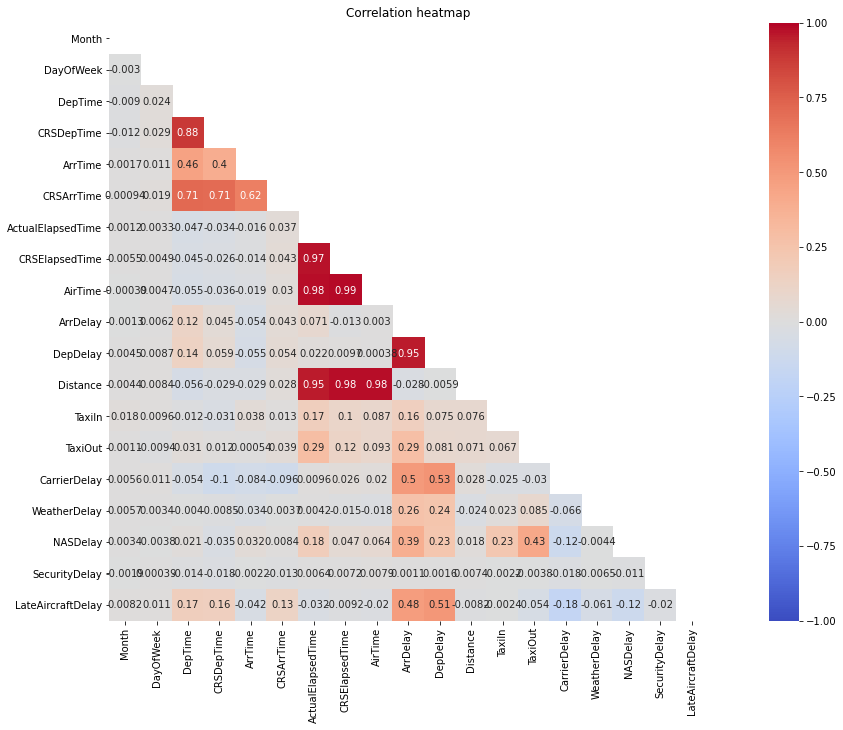

In [5]:
# what´s the realtion between variables?
correlac = df_raw.corr()
mascara = np.triu(correlac)
f, ax = plt.subplots(figsize=(22, 11))
sns.heatmap(correlac, square=True, mask=mascara, annot=True, cmap='coolwarm', vmin=-1, vmax=1);
ax.set_title('Correlation heatmap')
plt.show()

In [6]:
# Create a copy in case I need data I delete
df = df_raw.copy()  # por default deep es True, con lo cual los cambios en df no alteran df_raw

"Correlated Attributes: Some algorithms degrade in importance with the existence of highly correlated attributes. Pairwise attributes with high correlation can be identified and the most correlated attributes can be removed from the data."

In [7]:
# Drop variables seen too correlated in the matrix
df = df.drop([ "ActualElapsedTime", 'CRSElapsedTime', 'AirTime'],1) # están altamente relacionadas con Distance
df = df.drop("CRSDepTime",1) # relacionada con DepTime
df = df.drop("CRSArrTime",1) # relacionada con DepTime
df.head()

,Month,DayOfWeek,DepTime,ArrTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
497550,3,7,2127,438,-62,7,2148,8,10,nan,nan,nan,nan,nan
1731259,11,4,1554,1834,-56,9,1989,6,20,nan,nan,nan,nan,nan
1916451,12,2,1815,2057,-53,10,2465,3,18,nan,nan,nan,nan,nan
47306,1,4,1945,2104,-51,10,766,7,28,nan,nan,nan,nan,nan
182763,1,5,1636,1931,-49,6,1989,4,25,nan,nan,nan,nan,nan


In [8]:
# Fill null values with 0 in all XXXDelay as analized in Srint 12 Task 01 
df['CarrierDelay'].fillna(0, inplace=True)
df['WeatherDelay'].fillna(0, inplace=True)
df['NASDelay'].fillna(0, inplace=True)
df['SecurityDelay'].fillna(0, inplace=True)
df['LateAircraftDelay'].fillna(0, inplace=True)

In [9]:
# Prepare the target variable "demorado" with 0 or 1
bins = [-200, 0, 1600]
valores = [0,1]
df['demorado'] = pd.cut(df['ArrDelay'], bins=bins, labels=valores)
# Drop ArrDelay
df.drop("ArrDelay",1, inplace=True)
df

,Month,DayOfWeek,DepTime,ArrTime,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,demorado
497550,3,7,2127,438,7,2148,8,10,0,0,0,0,0,0
1731259,11,4,1554,1834,9,1989,6,20,0,0,0,0,0,0
1916451,12,2,1815,2057,10,2465,3,18,0,0,0,0,0,0
47306,1,4,1945,2104,10,766,7,28,0,0,0,0,0,0
182763,1,5,1636,1931,6,1989,4,25,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517183,3,7,258,809,1193,1399,5,27,5,0,0,0,1184,1
1655337,11,6,900,1409,1240,1454,4,15,1230,0,0,0,0,1
1025817,6,1,1044,1532,1287,1175,8,21,1165,0,2,0,122,1
1027010,6,1,1258,1753,1358,1300,5,11,1344,0,0,0,0,1


In [10]:
df.demorado.value_counts()

1    143618
0     17079
Name: demorado, dtype: int64

In [11]:
# Drop even  some more features as in Sprint 12
df = df.drop(['Month', 'DayOfWeek', 'DepTime', 'ArrTime'],1)

In [12]:
# Split dataset in features and target variable
feature_cols = list(df.columns)
feature_cols.remove('demorado')
X = df[feature_cols].values # Features
y = df.demorado.values # Target variable

# Remember another way of doing this 
# X, y = df.iloc[:,:-1].values, df.iloc[:,-1]-values


# Split dataset into training set and test set, taking equivalent values of 'demorado' in each group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify =df.demorado)

## Exercici 1
Crear al menos tres modelos de clasificación para predecir si un vuelo llegará con demora

In [13]:
# Analize multiple models with lazypredict
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [04:51<00:00, 10.04s/it]


In [14]:
# Print up to 3 decimals
pd.options.display.float_format = '{:.3f}'.format
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.757,0.864,0.864,0.802,0.233
NearestCentroid,0.661,0.798,0.798,0.726,0.200
BaggingClassifier,0.888,0.694,0.694,0.887,2.347
DecisionTreeClassifier,0.876,0.682,0.682,0.877,0.484
XGBClassifier,0.908,0.679,0.679,0.899,3.657
LGBMClassifier,0.909,0.676,0.676,0.899,0.857
ExtraTreeClassifier,0.877,0.675,0.675,0.877,0.242
ExtraTreesClassifier,0.895,0.673,0.673,0.889,9.712
KNeighborsClassifier,0.895,0.670,0.670,0.888,46.935


We can see there´s a lot to analize, depending on what you want to maximize. For example KNN and SVC take a lot of running time. 

[(0.0, 1.0)]

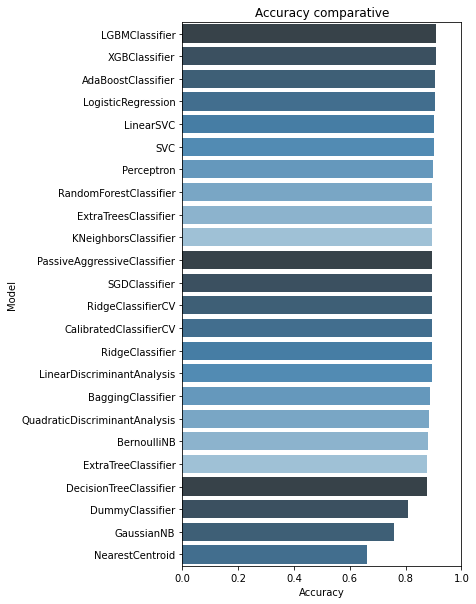

In [15]:
# Display ordered by Accuracy

lazy_df = pd.DataFrame(models).sort_values(by=['Accuracy'], ascending=False)

# reverse the palette color
palette = sns.color_palette("Blues_d", n_colors=10)
palette.reverse()

plt.figure(figsize=(5, 10))
ax = sns.barplot(y= lazy_df.index, x="Accuracy", data=lazy_df, palette=palette)
ax.set_title('Accuracy comparative')
ax.set(xlim=(0, 1))

### Ada Boost Classifier

In [62]:
# Create Ada Boost classifer object
abclf1 = AdaBoostClassifier()

# Train the Classifer
abclf1 = abclf1.fit(X_train,y_train)

#Predict the response for test dataset
y_pred1 = abclf1.predict(X_test)


### K-nearest neighbours

In [63]:
# Create and fit the model
kn1 = KNeighborsClassifier(n_neighbors=5)
kn1 = kn1.fit(X_train, y_train)

y_pred_kn1= kn1.predict(X_test)


### Logistic Regression

In [18]:
# Standarize the data for the model
# Before this I got a warning of non convergent problem
scaler = StandardScaler()

X_std = scaler.fit_transform(X)


In [64]:
# Split  standarized dataset into training set and test set
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=1)


# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_std, y_train)

y_pred_lg=logreg.predict(X_test_std)



## Exercici 2
Medir los modelos

In [106]:
models_list = [('AdaBoost',abclf1,False), ('KNNeighbours', kn1, False), ('Logistic Regression', logreg, True)]
scores_dict = {}

for name, clf, std in models_list:
    # si el modelo usó datos estandarizados necesito usar X_test_std
    if std:
        X_prueba = X_test_std
    else:
        X_prueba = X_test
        
    scores = {'Precision':metrics.precision_score(y_test, clf.predict(X_prueba)),
                'Recall':metrics.recall_score(y_test,clf.predict(X_prueba)),
                'Accuracy':metrics.accuracy_score(y_test, clf.predict(X_prueba)),
                'B-Accuracy':metrics.balanced_accuracy_score(y_test, clf.predict(X_prueba)),
                'F1 Score':metrics.f1_score(y_test, clf.predict(X_prueba)),
                'ROC area':metrics.roc_auc_score(y_test, clf.predict_proba(X_prueba)[:, 1]),
                'Confusion Matrix':confusion_matrix(y_test, clf.predict(X_prueba))}
    scores_dict[name] = scores
    
scores_df = pd.DataFrame.from_dict(scores_dict).transpose()

scores_df

,Precision,Recall,Accuracy,B-Accuracy,F1 Score,ROC area,Confusion Matrix
AdaBoost,0.893,1.000,0.893,0.500,0.944,0.504,"[[0, 5154], [1, 43055]]"
KNNeighbours,0.893,0.990,0.885,0.500,0.939,0.497,"[[49, 5105], [436, 42620]]"
Logistic Regression,0.917,0.980,0.903,0.621,0.948,0.929,"[[1352, 3802], [851, 42205]]"


In the confussion matrix we can see Logistic Regression is, by far, the model that has less false positvies. If I choose to minimize this, it's the best model. Also oyher scores are better in this model.  

The AUC 0,500 means the predictors are the same as the Dummy Classifier. This is no good. 

<AxesSubplot:title={'center':'Meditions for differente models'}>

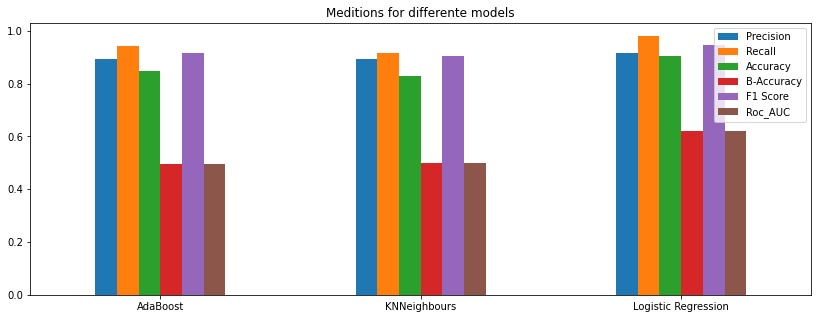

In [21]:
scores_df.plot(kind='bar', figsize =(14,5), rot=0, title='Meditions for differente models')


In [22]:
# The normalized confussion matrix:

# For Ada Boost we have:
cf_ab = confusion_matrix(y_test, y_pred1, normalize='true')

# Also the above information can be achieved with:
# cr_ab = classification_report(y_test, y_pred1)

# For knn:
cf_knn = confusion_matrix(y_test, y_pred_kn1, normalize='true')

# For Logistic Regression:
cf_lr = confusion_matrix(y_test, y_pred_lg, normalize='true')

# Precision: When a positive value is predicted, how often is the prediction correct?


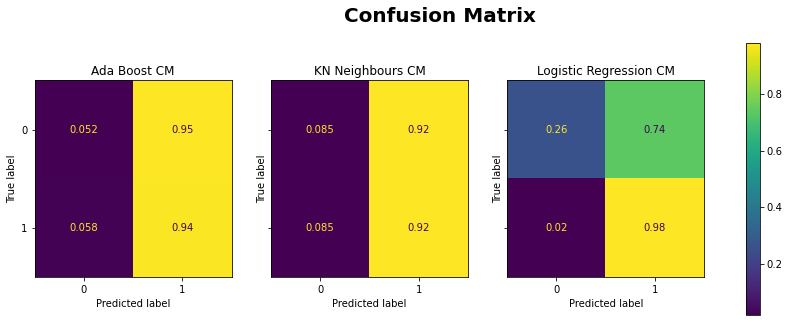

In [23]:
# Plot confusion matrix

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey='row')

cmview = metrics.ConfusionMatrixDisplay(cf_ab)
cmview.plot(ax=ax[0])
cmview.ax_.set_title('Ada Boost CM')
cmview.im_.colorbar.remove()

cmview = metrics.ConfusionMatrixDisplay(cf_knn)
cmview.plot(ax=ax[1])
cmview.ax_.set_title('KN Neighbours CM')
cmview.im_.colorbar.remove()
   
cmview = metrics.ConfusionMatrixDisplay(cf_lr)
cmview.plot(ax=ax[2])
cmview.ax_.set_title('Logistic Regression CM')
cmview.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.20, hspace=0.1)
fig.colorbar(cmview.im_, ax=ax)
fig.suptitle('Confusion Matrix', fontsize = 20, fontweight = "bold", ha='center')
plt.show()



The first two models, have a high TP but also a high FP. They both label a lot positive and have very little TN. Logistic Regression seems more appropiate.

The reason could be that the sample has a little percentage of negatives to analize. I made sure the percentage in the sample was the same that the one from the dataset, the thing is the dataset also had little negative examples. A good approach could be apply a technique of Imbalanced Classification such as SMOTE. 

Text(0.5, 257.44, 'Predicted label')

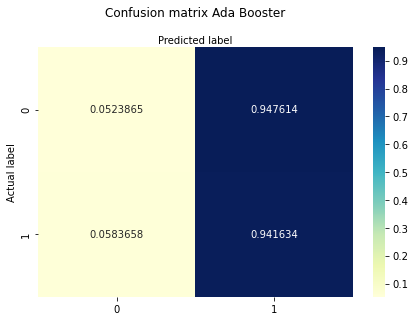

In [24]:
# I can also create the matrix by hand with:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cf_ab), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Ada Booster', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

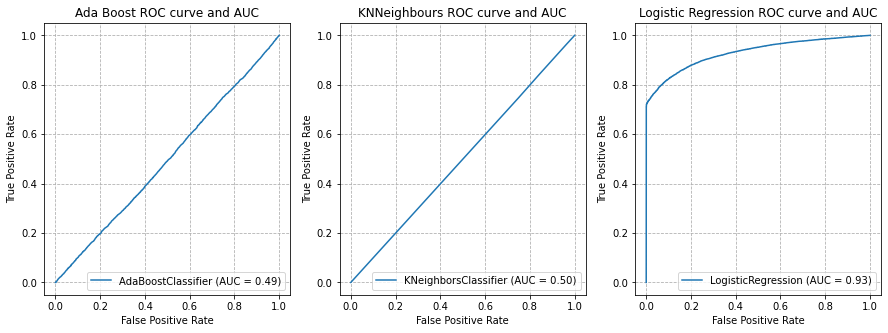

In [25]:
# ROC curve, AUC values and Detection Error tradeoff
fig, [ax_ab, ax_knn, ax_lg] = plt.subplots(1, 3, figsize=(15, 5))

plot_roc_curve(abclf1, X_test, y_test, ax=ax_ab)

plot_roc_curve(kn1, X_test, y_test, ax=ax_knn)

plot_roc_curve(logreg, X_test_std, y_test, ax=ax_lg)

#fig.set_title('Receiver Operating Characteristic (ROC) curves')

ax_ab.set_title('Ada Boost ROC curve and AUC')
ax_ab.grid(linestyle='--')

ax_knn.set_title('KNNeighbours ROC curve and AUC')
ax_knn.grid(linestyle='--')

ax_lg.set_title('Logistic Regression ROC curve and AUC')
ax_lg.grid(linestyle='--')

plt.legend()
plt.show()

In [26]:
# Both predict and predict_proba can be used to calculate AUC
# print(metrics.roc_auc_score(y_test, abclf1.predict_proba(X_test)[:, 1]))
# print(metrics.roc_auc_score(y_test, abclf1.predict(X_test)))


## Exercici 3
Entrenar los modelos con otros parámetros

In [108]:
# Create Ada Boost classifer object with new parameters
abclf2 = AdaBoostClassifier(n_estimators = 200, algorithm='SAMME', random_state=5)

# Train Ada Boost Classifer
abclf2 = abclf2.fit(X_train,y_train)

#Predict the response for test dataset
y_pred2 = abclf2.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
print('AUC:', metrics.roc_auc_score(y_test, y_pred2))

Accuracy: 0.8930927193528314
AUC: 0.5


0.5000846511972316

There´s no improvement in accuracy with these parameters.

In [28]:
# Knn with different number of neighbours
error = []

# Calculating error for K values between 3 and 20
for i in range(3, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

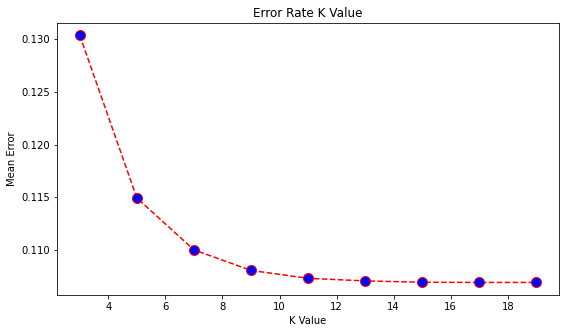

In [29]:
# Plotting the mean error for each number of neighbours
plt.figure(figsize=(9, 5))
plt.plot(range(3, 20, 2), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Mean error seems lower for k greater than 14. Let´s see accuracy and AUC:

In [111]:
# Create and fit the model
kn2 = KNeighborsClassifier(n_neighbors=15, weights = 'distance', n_jobs = -1)
kn2 = kn2.fit(X_train, y_train)
, 
y_pred_kn2= kn2.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_kn2))
print('AUC:', metrics.roc_auc_score(y_test, kn2.predict_proba(X_test)[:, 1]))

Accuracy: 0.8918066791122173
AUC: 0.49465244620284604


The difference with the original parameters is really small. 

In [112]:
# Create and fit the model
kn3 = KNeighborsClassifier(n_neighbors=55, weights = 'distance', n_jobs = -1)
kn3 = kn3.fit(X_train, y_train)
, 
y_pred_kn3= kn3.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_kn3))
print('AUC:', metrics.roc_auc_score(y_test, kn3.predict_proba(X_test)[:, 1]))

Accuracy: 0.8919311346193736
AUC: 0.4948416485007946


In [114]:
# Logistic regression with different parameters
logreg2 = LogisticRegression(max_iter=2000, solver= 'liblinear', verbose=1, random_state=4)

# fit the model with data
logreg2.fit(X_train_std, y_train)

y_pred_lg=logreg2.predict(X_test_std)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred_lg))
print('AUC:', metrics.roc_auc_score(y_test, logreg2.predict_proba(X_test_std)[:, 1]))

[LibLinear]Accuracy: 0.9035054967848994
AUC: 0.9292796567504582


The result is the same as before.

### Before Exercice 4, let´s add another model: Neural Network


In [120]:
mlp = MLPClassifier(hidden_layer_sizes=(8,12,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

predict_test = mlp.predict(X_test)
print('Confussion Matrix:', confusion_matrix(y_test,predict_test))
print('Classification report:', classification_report(y_test,predict_test))
print('AUC:', metrics.roc_auc_score(y_test, predict_test))

Confussion Matrix: [[    0  5154]
 [    0 43056]]
Classification report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5154
           1       0.89      1.00      0.94     43056

    accuracy                           0.89     48210
   macro avg       0.45      0.50      0.47     48210
weighted avg       0.80      0.89      0.84     48210

AUC: 0.5


Accuracy is looking good, but we never get negative predictions! Also AUC is bad. Let´s change the size of the network.

In [122]:
mlp = MLPClassifier(hidden_layer_sizes=(200,820,200), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

predict_test = mlp.predict(X_test)
print('Confussion Matrix:', confusion_matrix(y_test,predict_test))
print('Classification report:', classification_report(y_test,predict_test))
print('AUC:', metrics.roc_auc_score(y_test, predict_test))

Confussion Matrix: [[    0  5154]
 [    1 43055]]
Classification report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5154
           1       0.89      1.00      0.94     43056

    accuracy                           0.89     48210
   macro avg       0.45      0.50      0.47     48210
weighted avg       0.80      0.89      0.84     48210

AUC: 0.49998838721664807


Again, there is not much difference. 

### Exercici 4
Comprar los modelos usando train / test o cross-validation

Until now the models were evaluated using train/test. In this exercice I'll use cross-validation   

In [35]:
# With train/test we had:
print('Accuracy for Ada Boost:', metrics.accuracy_score(y_test, y_pred1))
print('Accuracy for KNN:', metrics.accuracy_score(y_test, y_pred_kn1))
print('Accuracy for Logistic Regression:', metrics.accuracy_score(y_test, logreg.predict(X_test_std)))

Accuracy for Ada Boost: 0.8465671022609417
Accuracy for KNN: 0.826654221115951
Accuracy for Logistic Regression: 0.9035054967848994


In [36]:
# Evaluating the same models with cross-validation with 3 folds gives de following results:
print('Ada Boost:', cross_val_score(abclf1, X, y, cv=3))
print('KNNeighbours:', cross_val_score(kn1, X, y, cv=3))
print('Logistic Regression:', cross_val_score(logreg, X_std, y, cv=3))  # this model was trained with standarized data

Ada Boost: [0.2595863  0.91076429 0.90667413]
KNNeighbours: [0.25835418 0.92000523 0.91752077]
[LibLinear][LibLinear][LibLinear]Logistic Regression: [0.2595863  0.90381959 0.90131616]


Seems that the models don´t work well. But could there be another reason for this results?

In [37]:
y

[0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1]
Length: 160697
Categories (2, int64): [0 < 1]

The data was sorted by ArrDelay in the beginning of the notebook. So the first fold has most 0 and the next ones have mostly 1. I need to shuffle the data. The folds need to be stratified, because there´s a lot more 1 than 0.

In [38]:
# Stratified KFold with shuffle in True
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(X, y)

3

In [39]:
i = 1
for train_index, test_index in skf.split(X, y):
    X_train_skf, X_test_skf = X[train_index], X[test_index]
    y_train_skf, y_test_skf = y[train_index], y[test_index]
    print(f"Accuracy for Ada Boost for the fold no. {i} on the test set: {metrics.accuracy_score(y_test_skf, abclf1.predict(X_test_skf))}")
    i += 1
    
i = 1
for train_index, test_index in skf.split(X, y):
    X_train_skf, X_test_skf = X[train_index], X[test_index]
    y_train_skf, y_test_skf = y[train_index], y[test_index]
    print(f"Accuracy for KNN for the fold no. {i} on the test set: {metrics.accuracy_score(y_test_skf, kn1.predict(X_test_skf))}")
    i += 1
    

Accuracy for Ada Boost for the fold no. 1 on the test set: 0.9055744315423963
Accuracy for Ada Boost for the fold no. 2 on the test set: 0.9078146585520666
Accuracy for Ada Boost for the fold no. 3 on the test set: 0.9051619527676654
Accuracy for KNN for the fold no. 1 on the test set: 0.9196131874696636
Accuracy for KNN for the fold no. 2 on the test set: 0.9208639808833962
Accuracy for KNN for the fold no. 3 on the test set: 0.9191262951554187


So the problem was not with the models but with the folds built by the cross-validation. In fact, the result is a little better than with train/test.

## Exercici 5
Realizar una ingeniería de variables para mejorar la predicción

### Balancing data with SMOTE

I believe the model can improve if the target is a balanced. At the moment we have:
    

<AxesSubplot:title={'center':'Values of the target variable'}, ylabel='demorado'>

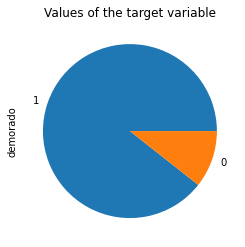

In [40]:
counts = df.demorado.value_counts()
# use a pie plot
counts.plot(kind='pie', y=df.demorado, title='Values of the target variable')

In [41]:
# Apply SMOTE for varable balancing
smote = SMOTE(random_state=1, sampling_strategy = 'minority')

# Need more values 0 in "demorado" 
X_sm, y_sm = smote.fit_resample(X, y)



In [42]:
df_sm = pd.DataFrame(y_sm, columns =['demorado'])

<AxesSubplot:title={'center':'Values of the target variable after SMOTE'}, ylabel='demorado'>

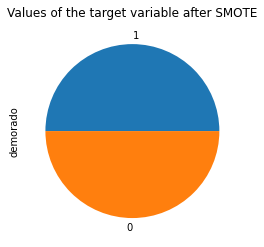

In [43]:
counts = df_sm.demorado.value_counts()
# use a pie plot
counts.plot(kind='pie', y=y_sm, title='Values of the target variable after SMOTE')

In [44]:
# Split dataset into training set and test set
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.3, random_state=20)

Accuracy: 0.8886168200438662


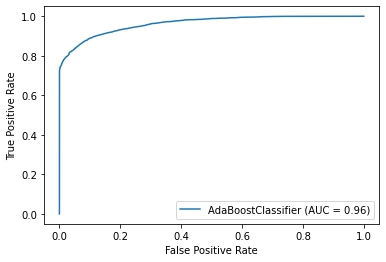

In [126]:
# Create Ada Boost classifer object with SMOTE
ab2 = AdaBoostClassifier()

# Train the Classifer
ab2 = ab2.fit(X_train_sm,y_train_sm)

#Predict the response for test dataset
y_pred2 = ab2.predict(X_test_sm)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_sm, y_pred2))
plot_roc_curve(ab2, X_test_sm, y_test_sm)

###  Standarizing the SMOTE balanced data 

In [125]:
# Standarize the data for the model with SMOTE
scaler = StandardScaler()

X_train_sm_std = scaler.fit_transform(X_train_sm)
X_test_sm_std = scaler.fit_transform(X_test_sm)

Accuracy: 0.8678209606480138


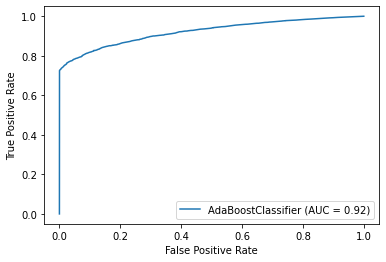

In [127]:
# Create Ada Boost classifer object with standarized data and SMOTE
ab_std = AdaBoostClassifier()

# Train the Classifer
ab_std = ab_std.fit(X_train_sm_std,y_train_sm)

#Predict the response for test dataset
y_pred3 = ab_std.predict(X_test_sm_std)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_sm, y_pred3))
plot_roc_curve(ab_std, X_test_sm_std, y_test_sm)

A good result but not as good as the previous one

### Use standarized data

Accuracy: 0.9055175274839244


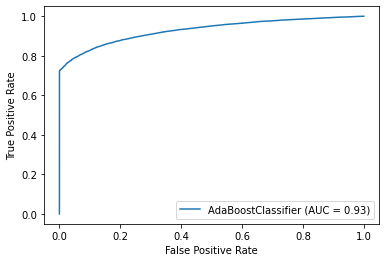

In [128]:
# Create Ada Boost classifer object with standarized data only (SMOTE not applied)
ab_std2 = AdaBoostClassifier()

# Train the Classifer
ab_std2 = ab_std2.fit(X_train_std,y_train)

#Predict the response for test dataset
y_pred4 = ab_std2.predict(X_test_std)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred4))
plot_roc_curve(ab_std2, X_test_std, y_test)

Also a good result.

### Try with normalized data

In [49]:
# Normalizethe data for the model
norm = Normalizer()

X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)

Accuracy: 0.8930512341837793


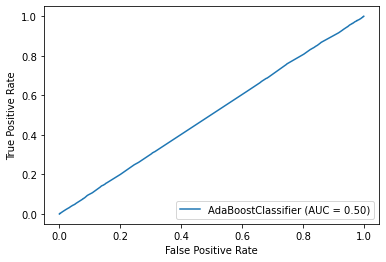

In [129]:
# Create Ada Boost classifer object with normalized data
ab_n = AdaBoostClassifier()

# Train the Classifer
ab_n = ab_n.fit(X_train_n,y_train)

#Predict the response for test dataset
y_pred5 = ab_n.predict(X_test_n)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred5))
plot_roc_curve(ab_n, X_test_n, y_test)

Normalizing doesn´t seem like a good idea. 

### Apply PCA

In [51]:
# use PCA to decrease feature dimension
# instanciate PCA
pca = PCA(n_components=0.95, svd_solver='full')
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.fit_transform(X_test)


Accuracy: 0.8930927193528314


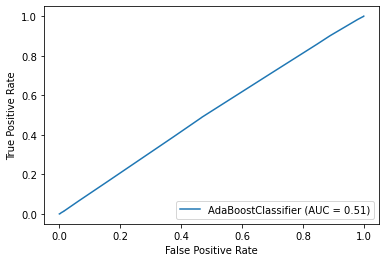

In [130]:
# Create Ada Boost classifer object with PCA modified data (95% accuracy)
ab_PCA = AdaBoostClassifier()

# Train the Classifer
ab_PCA = ab_PCA.fit(X_train_PCA,y_train)

#Predict the response for test dataset
y_pred6 = ab_PCA.predict(X_test_PCA)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred6))
plot_roc_curve(ab_PCA, X_test_PCA, y_test)

Again the same result, no improvement.

### Reduce outliers

In [53]:
# Count outliers for every variable
Q1 = df[feature_cols].quantile(0.25)
Q3 = df[feature_cols].quantile(0.75)
IQR = Q3 - Q1
    
outliers_bool = (df[feature_cols] < (Q1 - 1.5 * IQR)) |(df[feature_cols] > (Q3 + 1.5 * IQR))
outliers = outliers_bool.sum(axis=0)
outliers

DepDelay             12657
Distance              8130
TaxiIn                8369
TaxiOut              10677
CarrierDelay         22120
WeatherDelay          8394
NASDelay             24935
SecurityDelay          496
LateAircraftDelay    19263
dtype: int64

In [54]:
# They represent x% of the values:
100* outliers / df.shape[0]

DepDelay             7.876
Distance             5.059
TaxiIn               5.208
TaxiOut              6.644
CarrierDelay        13.765
WeatherDelay         5.223
NASDelay            15.517
SecurityDelay        0.309
LateAircraftDelay   11.987
dtype: float64

In [148]:
# Create a new Delay variable in a copy, not to loose df
df_red = df.copy()
df_red['XXXDelay'] = df.CarrierDelay + df.WeatherDelay + df.NASDelay + df.SecurityDelay + df.LateAircraftDelay
df_red

,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,demorado,XXXDelay
497550,7.000,2148,8.000,10.000,0.000,0.000,0.000,0.000,0.000,0,0.000
1731259,9.000,1989,6.000,20.000,0.000,0.000,0.000,0.000,0.000,0,0.000
1916451,10.000,2465,3.000,18.000,0.000,0.000,0.000,0.000,0.000,0,0.000
47306,10.000,766,7.000,28.000,0.000,0.000,0.000,0.000,0.000,0,0.000
182763,6.000,1989,4.000,25.000,0.000,0.000,0.000,0.000,0.000,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...
517183,1193.000,1399,5.000,27.000,5.000,0.000,0.000,0.000,1184.000,1,1189.000
1655337,1240.000,1454,4.000,15.000,1230.000,0.000,0.000,0.000,0.000,1,1230.000
1025817,1287.000,1175,8.000,21.000,1165.000,0.000,2.000,0.000,122.000,1,1289.000
1027010,1358.000,1300,5.000,11.000,1344.000,0.000,0.000,0.000,0.000,1,1344.000


In [149]:
df_red.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], 1, inplace = True)

In [150]:
columns = df_red.columns
print(columns)
columns = columns.delete(4)
df_red[columns]

Index(['DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'demorado', 'XXXDelay'], dtype='object')


,DepDelay,Distance,TaxiIn,TaxiOut,XXXDelay
497550,7.000,2148,8.000,10.000,0.000
1731259,9.000,1989,6.000,20.000,0.000
1916451,10.000,2465,3.000,18.000,0.000
47306,10.000,766,7.000,28.000,0.000
182763,6.000,1989,4.000,25.000,0.000
...,...,...,...,...,...
517183,1193.000,1399,5.000,27.000,1189.000
1655337,1240.000,1454,4.000,15.000,1230.000
1025817,1287.000,1175,8.000,21.000,1289.000
1027010,1358.000,1300,5.000,11.000,1344.000


In [151]:
# Count outliers for every variable
Q1 = df_red[columns].quantile(0.25)
Q3 = df_red[columns].quantile(0.75)
IQR = Q3 - Q1
    
outliers_bool = (df_red[columns] < (Q1 - 1.5 * IQR)) |(df_red[columns] > (Q3 + 1.5 * IQR))
outliers = outliers_bool.sum(axis=0)
outliers

DepDelay    12657
Distance     8130
TaxiIn       8369
TaxiOut     10677
XXXDelay     9111
dtype: int64

In [152]:
# They represent x% of the values:
100* outliers / df.shape[0]

DepDelay   7.876
Distance   5.059
TaxiIn     5.208
TaxiOut    6.644
XXXDelay   5.670
dtype: float64

In [153]:
# Split into train and test
X_red = df_red[columns].values # Features
y_red = df_red.demorado.values # Target variable

# Split dataset into training set and test set, taking equivalent values of 'demorado' in each group
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red, test_size=0.3, random_state=1, stratify =df.demorado)

I have less percentage of outliers now. Let´s apply the model now.

Accuracy: 0.9053723293922423


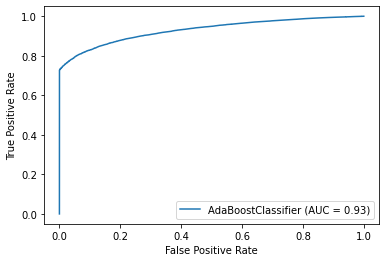

In [154]:
# Create Ada Boost classifer object with less outliers
ab_red = AdaBoostClassifier()

# Train the Classifer
ab_red = ab_red.fit(X_train_red,y_train_red)

#Predict the response for test dataset
y_pred7 = ab_red.predict(X_test_red)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_red, y_pred7))
plot_roc_curve(ab_red, X_test_red, y_test_red)

This approach is also good!!

## Exercici 6

No utilizar la variable DepDelay

In [155]:
df_red.drop(['DepDelay'],1 , inplace=True)

In [158]:
y = df_red['demorado']
X = df_red.drop(['demorado'],1)
X

,Distance,TaxiIn,TaxiOut,XXXDelay
497550,2148,8.000,10.000,0.000
1731259,1989,6.000,20.000,0.000
1916451,2465,3.000,18.000,0.000
47306,766,7.000,28.000,0.000
182763,1989,4.000,25.000,0.000
...,...,...,...,...
517183,1399,5.000,27.000,1189.000
1655337,1454,4.000,15.000,1230.000
1025817,1175,8.000,21.000,1289.000
1027010,1300,5.000,11.000,1344.000


In [159]:
# Apply SMOTE for varable balancing
smote = SMOTE(random_state=1, sampling_strategy = 'minority')

# Need more values 0 in "demorado" 
X_sm, y_sm = smote.fit_resample(X, y)


In [160]:
# Split dataset into training set and test set
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.3, random_state=20)

Accuracy: 0.8682039201123348


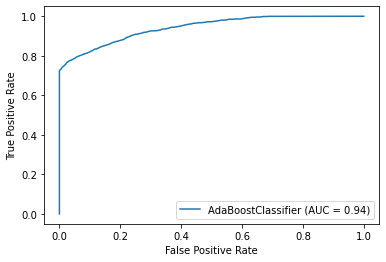

In [162]:
# Create Ada Boost classifer object
ab8 = AdaBoostClassifier()

# Train the Classifer
ab8 = ab8.fit(X_train_sm,y_train_sm)

#Predict the response for test dataset
y_pred8 = ab8.predict(X_test_sm)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_sm, y_pred8))
plot_roc_curve(ab8, X_test_sm, y_test_sm)

The model predicts quite well, even though it doesnt´have DepDelay